In [1]:
##Rebecca Lewis
#DSC 630
#Dog BinaryClassModel

In [2]:
import pandas as pd, numpy as np
from sklearn.model_selection import train_test_split
from sklearn import metrics
from matplotlib import pyplot as plt
from yellowbrick.model_selection import FeatureImportances
from yellowbrick.regressor import ResidualsPlot
from sklearn.utils import resample
from sklearn.linear_model import LogisticRegression
from yellowbrick.classifier import ConfusionMatrix
from yellowbrick.classifier import ClassificationReport
from yellowbrick.classifier import ROCAUC
from sklearn.metrics import roc_auc_score
from sklearn.svm import SVC
from sklearn.ensemble import RandomForestClassifier

#https://elitedatascience.com/imbalanced-classes
    
#upsample with logistic regression
#downsample with logistic regression
#penalized svm
#randomforest

C:\Users\rvick\Anaconda3\envs\R_Python\lib\site-packages\sklearn\utils\deprecation.py:143: FutureWarning: The sklearn.metrics.classification module is  deprecated in version 0.22 and will be removed in version 0.24. The corresponding classes / functions should instead be imported from sklearn.metrics. Anything that cannot be imported from sklearn.metrics is now part of the private API.
  warnings.warn(message, FutureWarning)


In [3]:
#read in data files
dogdata = pd.read_csv('Project_R_scripts\dogdata.csv') 

In [4]:
dogdata.columns

#remove outcome weekday when creating features
dog_columns = ['IntakeMonth', 'IntakeWeekday', 'Log10AgeInMonths',
       'Male', 'AsilomarImprovement', 'HealthyAsilomar', 'TreatRehabAsilomar',
       'TreatManAsilomar', 'UnhealthyAsilomar', 'Emaciated', 'Feral',
       'Heartworm', 'SickInjured', 'SkinIssue', 'SurrenderIntake',
       'SeizeCustodyIntake', 'StrayIntake', 'TransferIntake', 'SmallAnimal',
       'AlteredAtIntake', 'Foster', 'Offsite', 'DogEncouragement', 'DogMixed',
       'DogPitBullType']

dog_features = dogdata[dog_columns]
dog_target = dogdata['AdoptedInSevenDays']


In [5]:
#split into train and testing sets
dog_X_train, dog_X_test, dog_y_train, dog_y_test = train_test_split(dog_features, dog_target, 
                                                                    test_size =0.33, random_state=0, stratify=dog_target)
# number of samples in each set
print("No. of samples in training set: ", dog_X_train.shape[0])
print("No. of samples in validation set:", dog_X_test.shape[0])

No. of samples in training set:  3628
No. of samples in validation set: 1788


In [6]:
#dog upsampling
# combine the features and target for the training set
#only upsampling the training dataset
dog_training = pd.concat([dog_X_train, dog_y_train], axis=1)

In [7]:
dog_training['AdoptedInSevenDays'].value_counts()

0    3179
1     449
Name: AdoptedInSevenDays, dtype: int64

In [8]:
dog_majority = dog_training[dog_training.AdoptedInSevenDays==0]
dog_minority = dog_training[dog_training.AdoptedInSevenDays==1]

In [9]:
# Upsample minority class
dog_minority_upsampled = resample(dog_minority, 
                                 replace=True,     # sample with replacement
                                 n_samples=3179,    # to match majority class
                                 random_state=0) # reproducible results

In [10]:
# Combine majority class with upsampled minority class
dog_training_upsampled = pd.concat([dog_majority, dog_minority_upsampled])

In [11]:
# Display new class counts
dog_training_upsampled.AdoptedInSevenDays.value_counts()

1    3179
0    3179
Name: AdoptedInSevenDays, dtype: int64

In [12]:
dog_upsampled_target = dog_training_upsampled['AdoptedInSevenDays']
dog_upsampled_features = dog_training_upsampled.drop("AdoptedInSevenDays", axis=1)

In [13]:
from sklearn.preprocessing import StandardScaler

reg = LogisticRegression()
scaler = StandardScaler()

scaledfeatures = scaler.fit_transform(dog_upsampled_features)

# Train model

 
dog_upsample_model = reg.fit(scaledfeatures, dog_upsampled_target)


In [14]:
scaledtestfeatures = scaler.transform(dog_X_test)

# Predict on training set
dog_upsample_pred = dog_upsample_model.predict(scaledtestfeatures)

In [15]:
print(metrics.accuracy_score(dog_upsample_pred, dog_y_test) )
print(metrics.recall_score(dog_upsample_pred, dog_y_test) )

0.6308724832214765
0.21456436931079323


In [16]:
print(metrics.classification_report(dog_upsample_pred, dog_y_test) )

              precision    recall  f1-score   support

           0       0.61      0.95      0.74      1019
           1       0.75      0.21      0.33       769

    accuracy                           0.63      1788
   macro avg       0.68      0.58      0.54      1788
weighted avg       0.67      0.63      0.57      1788



In [17]:
#get predicted probabilites for roc score
prob_upsample_y = dog_upsample_model.predict_proba(scaledfeatures)
 
# Keep only the positive class
prob_upsample_y = [p[1] for p in prob_upsample_y]

print(metrics.roc_auc_score(dog_upsampled_target, prob_upsample_y) )

0.7479103340269448


C:\Users\rvick\Anaconda3\envs\R_Python\lib\site-packages\sklearn\base.py:213: FutureWarning: From version 0.24, get_params will raise an AttributeError if a parameter cannot be retrieved as an instance attribute. Previously it would return None.
  FutureWarning)


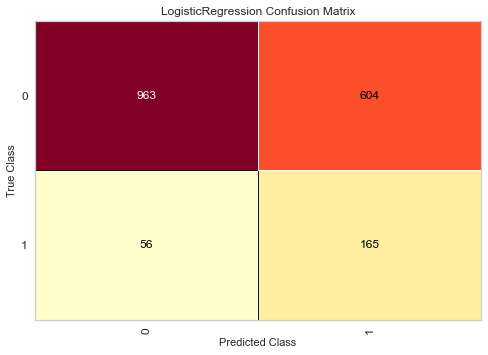

In [18]:
cm = ConfusionMatrix(reg)
cm.fit(scaledfeatures, dog_upsampled_target)
cm.score(scaledtestfeatures, dog_y_test)
cm.show()

C:\Users\rvick\Anaconda3\envs\R_Python\lib\site-packages\sklearn\base.py:213: FutureWarning: From version 0.24, get_params will raise an AttributeError if a parameter cannot be retrieved as an instance attribute. Previously it would return None.
  FutureWarning)


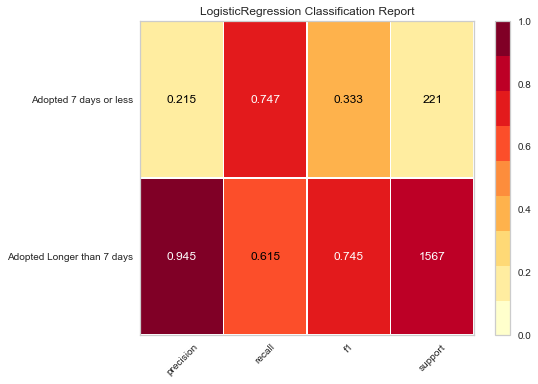

In [19]:
visualizer = ClassificationReport(reg, classes=['Adopted Longer than 7 days', 'Adopted 7 days or less'], support=True)

visualizer.fit(scaledfeatures, dog_upsampled_target)        # Fit the visualizer and the model
visualizer.score(scaledtestfeatures, dog_y_test)        # Evaluate the model on the test data
visualizer.show() 

C:\Users\rvick\Anaconda3\envs\R_Python\lib\site-packages\sklearn\base.py:213: FutureWarning: From version 0.24, get_params will raise an AttributeError if a parameter cannot be retrieved as an instance attribute. Previously it would return None.
  FutureWarning)


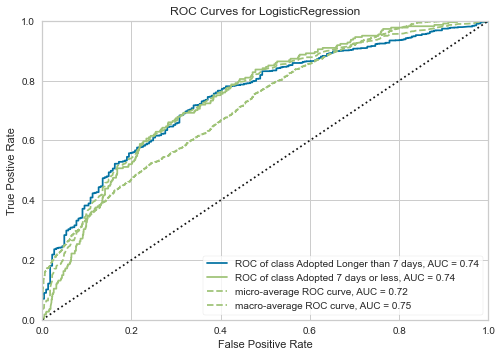

In [20]:
visualizer = ROCAUC(reg, classes=['Adopted Longer than 7 days', 'Adopted 7 days or less'])

visualizer.fit(scaledfeatures, dog_upsampled_target)        # Fit the visualizer and the model
visualizer.score(scaledtestfeatures, dog_y_test)        # Evaluate the model on the test data
visualizer.show() 

In [21]:
#downsample majority
# Downsample majority class
dog_majority_downsampled = resample(dog_majority, 
                                 replace=False,    # sample without replacement
                                 n_samples=449,     # to match minority class
                                 random_state=0) # reproducible results
 
# Combine minority class with downsampled majority class
dog_train_downsampled = pd.concat([dog_majority_downsampled, dog_minority])
 
# Display new class counts
dog_train_downsampled.AdoptedInSevenDays.value_counts()

1    449
0    449
Name: AdoptedInSevenDays, dtype: int64

In [22]:
dog_downsampled_target = dog_train_downsampled['AdoptedInSevenDays']
dog_downsampled_features = dog_train_downsampled.drop("AdoptedInSevenDays", axis=1)

In [23]:
reg = LogisticRegression()
scaler = StandardScaler()

scaledfeatures = scaler.fit_transform(dog_downsampled_features)

# Train model
dog_downsample_model = reg.fit(scaledfeatures, dog_downsampled_target)

scaledtestfeatures = scaler.transform(dog_X_test)

# Predict on testing set
dog_downsample_pred = dog_downsample_model.predict(scaledtestfeatures)
print(metrics.accuracy_score(dog_downsample_pred, dog_y_test) )
print(metrics.recall_score(dog_downsample_pred, dog_y_test) )

0.6174496644295302
0.21098626716604243


In [24]:
print(metrics.classification_report(dog_downsample_pred, dog_y_test) )

              precision    recall  f1-score   support

           0       0.60      0.95      0.73       987
           1       0.76      0.21      0.33       801

    accuracy                           0.62      1788
   macro avg       0.68      0.58      0.53      1788
weighted avg       0.67      0.62      0.55      1788



C:\Users\rvick\Anaconda3\envs\R_Python\lib\site-packages\sklearn\base.py:213: FutureWarning: From version 0.24, get_params will raise an AttributeError if a parameter cannot be retrieved as an instance attribute. Previously it would return None.
  FutureWarning)


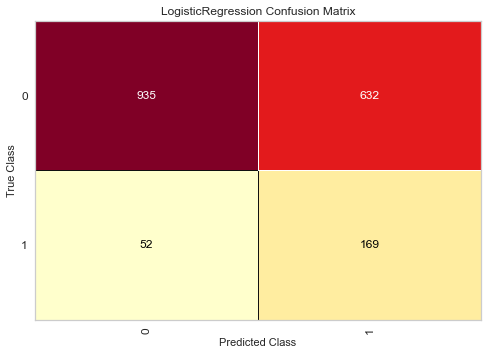

In [25]:
cm = ConfusionMatrix(reg)
cm.fit(scaledfeatures, dog_downsampled_target)
cm.score(scaledtestfeatures, dog_y_test)
cm.show()

C:\Users\rvick\Anaconda3\envs\R_Python\lib\site-packages\sklearn\base.py:213: FutureWarning: From version 0.24, get_params will raise an AttributeError if a parameter cannot be retrieved as an instance attribute. Previously it would return None.
  FutureWarning)


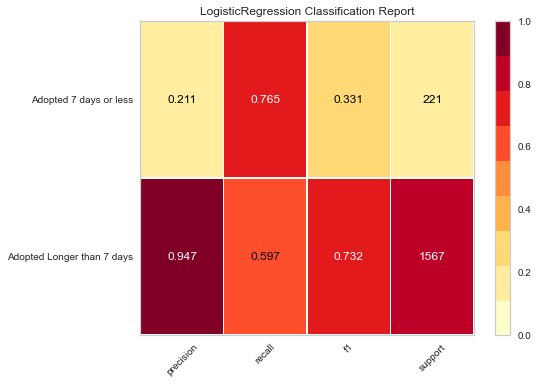

In [26]:
visualizer = ClassificationReport(reg, classes=['Adopted Longer than 7 days', 'Adopted 7 days or less'], support=True)

visualizer.fit(scaledfeatures, dog_downsampled_target)        # Fit the visualizer and the model
visualizer.score(scaledtestfeatures, dog_y_test)        # Evaluate the model on the test data
visualizer.show() 

C:\Users\rvick\Anaconda3\envs\R_Python\lib\site-packages\sklearn\base.py:213: FutureWarning: From version 0.24, get_params will raise an AttributeError if a parameter cannot be retrieved as an instance attribute. Previously it would return None.
  FutureWarning)


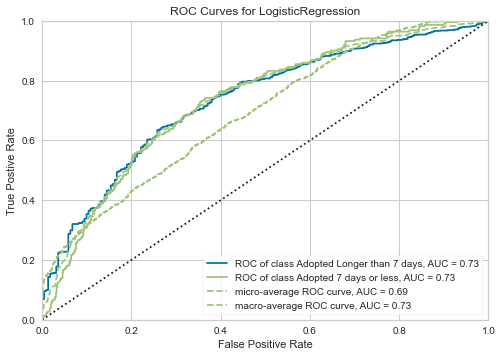

In [27]:
visualizer = ROCAUC(reg, classes=['Adopted Longer than 7 days', 'Adopted 7 days or less'])

visualizer.fit(scaledfeatures, dog_downsampled_target)        # Fit the visualizer and the model
visualizer.score(scaledtestfeatures, dog_y_test)        # Evaluate the model on the test data
visualizer.show() 

In [28]:
#get predicted probabilites for roc score
prob_downsample_y = dog_downsample_model.predict_proba(scaledfeatures)
 
# Keep only the positive class
prob_downsample_y = [p[1] for p in prob_downsample_y]
 
prob_downsample_y[:5]

[0.6158597993281482,
 0.648558017801495,
 0.820252052798205,
 0.5369252723135995,
 0.7438800196872726]

In [29]:
print( roc_auc_score(dog_downsampled_target, prob_downsample_y) )

0.7412587239150599


In [30]:
##Penalized Classes

# Train model
dog_svc_model = SVC(kernel='linear', 
            class_weight='balanced', # penalize
            probability=True)
 
dog_svc_model.fit(dog_X_train, dog_y_train)
 
# Predict on training set
dog_svc_pred = dog_svc_model.predict(dog_X_test)
 
# Is our model still predicting just one class?
print( np.unique( dog_svc_pred ) )

print( metrics.accuracy_score(dog_y_test, dog_svc_pred) )
print( metrics.recall_score(dog_y_test, dog_svc_pred) )

dog_prob_svc = dog_svc_model.predict_proba(dog_X_test)
dog_prob_svc = [p[1] for p in dog_prob_svc]
print( roc_auc_score(dog_y_test, dog_prob_svc) )


[0 1]
0.5883668903803132
0.755656108597285
0.7399576098663903


In [31]:
print(metrics.classification_report(dog_svc_pred, dog_y_test) )

              precision    recall  f1-score   support

           0       0.56      0.94      0.71       939
           1       0.76      0.20      0.31       849

    accuracy                           0.59      1788
   macro avg       0.66      0.57      0.51      1788
weighted avg       0.66      0.59      0.52      1788



C:\Users\rvick\Anaconda3\envs\R_Python\lib\site-packages\sklearn\base.py:213: FutureWarning: From version 0.24, get_params will raise an AttributeError if a parameter cannot be retrieved as an instance attribute. Previously it would return None.
  FutureWarning)


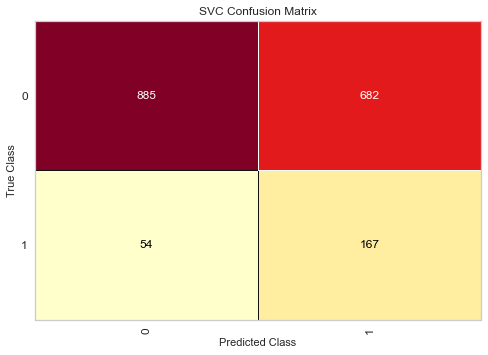

In [32]:
cm = ConfusionMatrix(dog_svc_model)
cm.fit(dog_X_train, dog_y_train)
cm.score(dog_X_test, dog_y_test)
cm.show()

C:\Users\rvick\Anaconda3\envs\R_Python\lib\site-packages\sklearn\base.py:213: FutureWarning: From version 0.24, get_params will raise an AttributeError if a parameter cannot be retrieved as an instance attribute. Previously it would return None.
  FutureWarning)


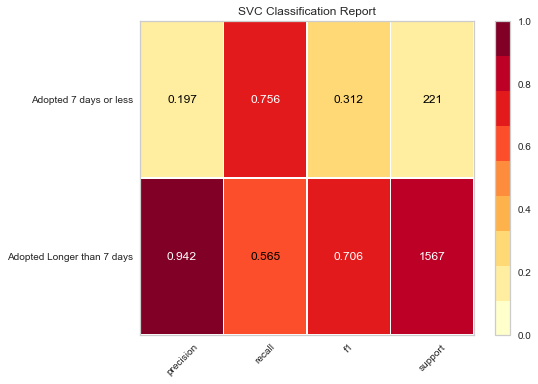

In [33]:
visualizer = ClassificationReport(dog_svc_model, classes=['Adopted Longer than 7 days', 'Adopted 7 days or less'], support=True)

visualizer.fit(dog_X_train, dog_y_train)       # Fit the visualizer and the model
visualizer.score(dog_X_test, dog_y_test)        # Evaluate the model on the test data
visualizer.show() 

C:\Users\rvick\Anaconda3\envs\R_Python\lib\site-packages\sklearn\base.py:213: FutureWarning: From version 0.24, get_params will raise an AttributeError if a parameter cannot be retrieved as an instance attribute. Previously it would return None.
  FutureWarning)


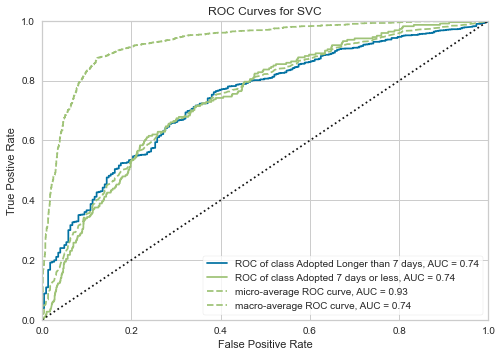

In [34]:
visualizer = ROCAUC(dog_svc_model, classes=['Adopted Longer than 7 days', 'Adopted 7 days or less'])

visualizer.fit(dog_X_train, dog_y_train)        # Fit the visualizer and the model
visualizer.score(dog_X_test, dog_y_test)        # Evaluate the model on the test data
visualizer.show() 

In [35]:
# Train model
dog_rf = RandomForestClassifier(class_weight='balanced', max_depth=3)
dog_rf_model = dog_rf.fit(dog_X_train, dog_y_train)
 
# Predict on training set
dog_rf_pred = dog_rf_model.predict(dog_X_test)

print( metrics.accuracy_score(dog_y_test, dog_rf_pred) )
print( metrics.recall_score(dog_y_test, dog_rf_pred) )

dog_rf_prob = dog_rf_model.predict_proba(dog_X_test)
dog_rf_prob = [p[1] for p in dog_rf_prob]
print( roc_auc_score(dog_y_test, dog_rf_prob) )



0.6325503355704698
0.7420814479638009
0.7401409731827541


In [36]:
print(metrics.classification_report(dog_rf_pred, dog_y_test) )

              precision    recall  f1-score   support

           0       0.62      0.94      0.75      1024
           1       0.74      0.21      0.33       764

    accuracy                           0.63      1788
   macro avg       0.68      0.58      0.54      1788
weighted avg       0.67      0.63      0.57      1788



C:\Users\rvick\Anaconda3\envs\R_Python\lib\site-packages\sklearn\base.py:213: FutureWarning: From version 0.24, get_params will raise an AttributeError if a parameter cannot be retrieved as an instance attribute. Previously it would return None.
  FutureWarning)


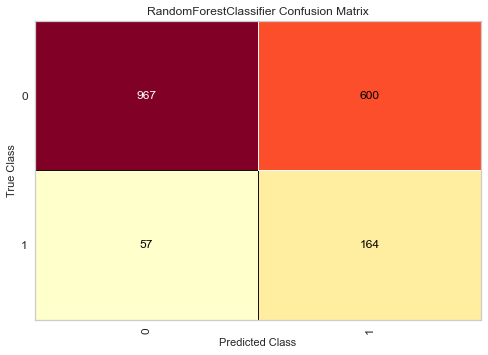

In [37]:
cm = ConfusionMatrix(dog_rf)
cm.fit(dog_X_train, dog_y_train)
cm.score(dog_X_test, dog_y_test)
cm.show()

In [38]:
#accuracy appears better but it is less accurate at predicting positives

C:\Users\rvick\Anaconda3\envs\R_Python\lib\site-packages\sklearn\base.py:213: FutureWarning: From version 0.24, get_params will raise an AttributeError if a parameter cannot be retrieved as an instance attribute. Previously it would return None.
  FutureWarning)


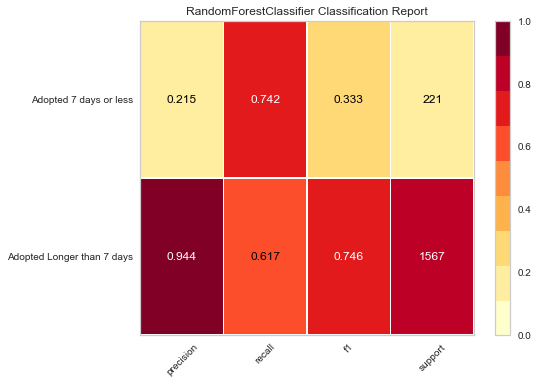

In [39]:
visualizer = ClassificationReport(dog_rf, classes=['Adopted Longer than 7 days', 'Adopted 7 days or less'], support=True)

visualizer.fit(dog_X_train, dog_y_train)       # Fit the visualizer and the model
visualizer.score(dog_X_test, dog_y_test)        # Evaluate the model on the test data
visualizer.show() 

C:\Users\rvick\Anaconda3\envs\R_Python\lib\site-packages\sklearn\base.py:213: FutureWarning: From version 0.24, get_params will raise an AttributeError if a parameter cannot be retrieved as an instance attribute. Previously it would return None.
  FutureWarning)


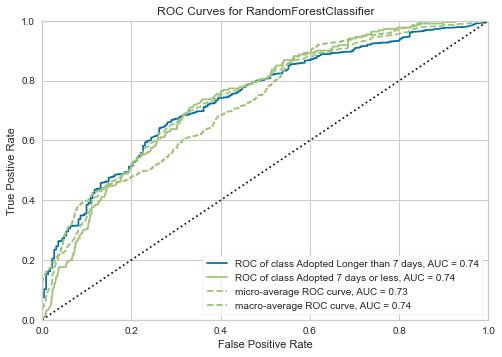

In [40]:
visualizer = ROCAUC(dog_rf, classes=['Adopted Longer than 7 days', 'Adopted 7 days or less'])

visualizer.fit(dog_X_train, dog_y_train)        # Fit the visualizer and the model
visualizer.score(dog_X_test, dog_y_test)        # Evaluate the model on the test data
visualizer.show() 

In [41]:
# Train model
dog_rf = RandomForestClassifier(class_weight='balanced', max_depth=5)
dog_rf_model = dog_rf.fit(dog_X_train, dog_y_train)
 
# Predict on training set
dog_rf_pred = dog_rf_model.predict(dog_X_test)

print( metrics.accuracy_score(dog_y_test, dog_rf_pred) )
print( metrics.recall_score(dog_y_test, dog_rf_pred) )

dog_rf_prob = dog_rf_model.predict_proba(dog_X_test)
dog_rf_prob = [p[1] for p in dog_rf_prob]
print( roc_auc_score(dog_y_test, dog_rf_prob) )



0.6929530201342282
0.665158371040724
0.7494087615901498


In [42]:
print(metrics.classification_report(dog_rf_pred, dog_y_test) )

              precision    recall  f1-score   support

           0       0.70      0.94      0.80      1166
           1       0.67      0.24      0.35       622

    accuracy                           0.69      1788
   macro avg       0.68      0.59      0.57      1788
weighted avg       0.69      0.69      0.64      1788



In [43]:
# Train model
dog_rf = RandomForestClassifier(class_weight='balanced', max_depth=8)
dog_rf_model = dog_rf.fit(dog_X_train, dog_y_train)
 
# Predict on training set
dog_rf_pred = dog_rf_model.predict(dog_X_test)

print( metrics.accuracy_score(dog_y_test, dog_rf_pred) )
print( metrics.recall_score(dog_y_test, dog_rf_pred) )

dog_rf_prob = dog_rf_model.predict_proba(dog_X_test)
dog_rf_prob = [p[1] for p in dog_rf_prob]
print( roc_auc_score(dog_y_test, dog_rf_prob) )



0.7130872483221476
0.6334841628959276
0.7505378176011458


In [44]:
print(metrics.classification_report(dog_rf_pred, dog_y_test) )

              precision    recall  f1-score   support

           0       0.72      0.93      0.82      1216
           1       0.63      0.24      0.35       572

    accuracy                           0.71      1788
   macro avg       0.68      0.59      0.58      1788
weighted avg       0.70      0.71      0.67      1788



C:\Users\rvick\Anaconda3\envs\R_Python\lib\site-packages\sklearn\base.py:213: FutureWarning: From version 0.24, get_params will raise an AttributeError if a parameter cannot be retrieved as an instance attribute. Previously it would return None.
  FutureWarning)


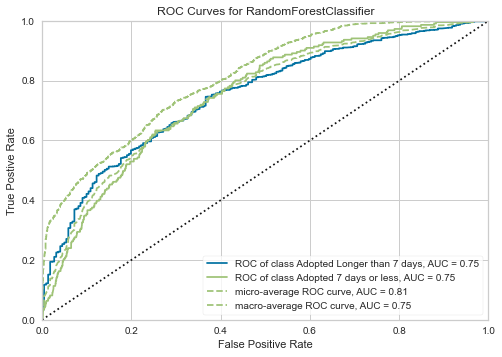

In [45]:
visualizer = ROCAUC(dog_rf, classes=['Adopted Longer than 7 days', 'Adopted 7 days or less'])

visualizer.fit(dog_X_train, dog_y_train)        # Fit the visualizer and the model
visualizer.score(dog_X_test, dog_y_test)        # Evaluate the model on the test data
visualizer.show() 

C:\Users\rvick\Anaconda3\envs\R_Python\lib\site-packages\sklearn\base.py:213: FutureWarning: From version 0.24, get_params will raise an AttributeError if a parameter cannot be retrieved as an instance attribute. Previously it would return None.
  FutureWarning)


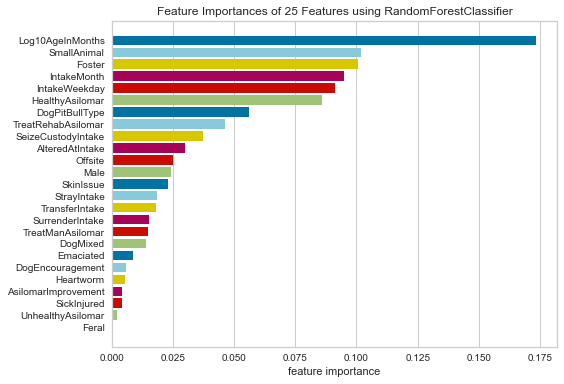

In [46]:
#Getting them from the random forest
from yellowbrick.model_selection import FeatureImportances

viz = FeatureImportances(RandomForestClassifier(class_weight='balanced', max_depth=8), relative=False)

# Fit and show the feature importances
viz.fit(dog_X_train, dog_y_train)
viz.show()